In [50]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import polytope
import system_id
import tqdm
import uncertainty_utils
import experiment_utils

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

In [51]:
TRACKING_LMPC = "tracking_mpc"
TV_LMPC = "naive_ltv_lmpc"
LBLMPC = "lblmpc"
LOCAL_LMPC = "local_ltv_lmpc"
TRUE_LMPC = "true_ltv_lmpc"
LTI_LMPC = "lti_lmpc"
TUBE_LMPC = "tube_ltv_lmpc"
controllers = [TRACKING_LMPC, TV_LMPC, LBLMPC, LOCAL_LMPC, TRUE_LMPC, LTI_LMPC, TUBE_LMPC]
save_dir = "dubin_car_expts/"

In [52]:
data = {controller:experiment_utils.load_results(save_dir, controller) for controller in controllers}

In [53]:
def compute_iteration_costs(data):
    iteration_costs = [q[0] for q in data["value_funcs"]]
    return iteration_costs
    
# iteration_costs = [np.vstack(compute_iteration_costs(experiment) for experiment in data[controller][(0,-1)]) for controller in controllers[1:]]

iteration_costs = [np.vstack((compute_iteration_costs(data[controller][-1]),compute_iteration_costs(data[controller][-2]), compute_iteration_costs(data[controller][-3]))) for controller in controllers[1:]]

(0, 3000)

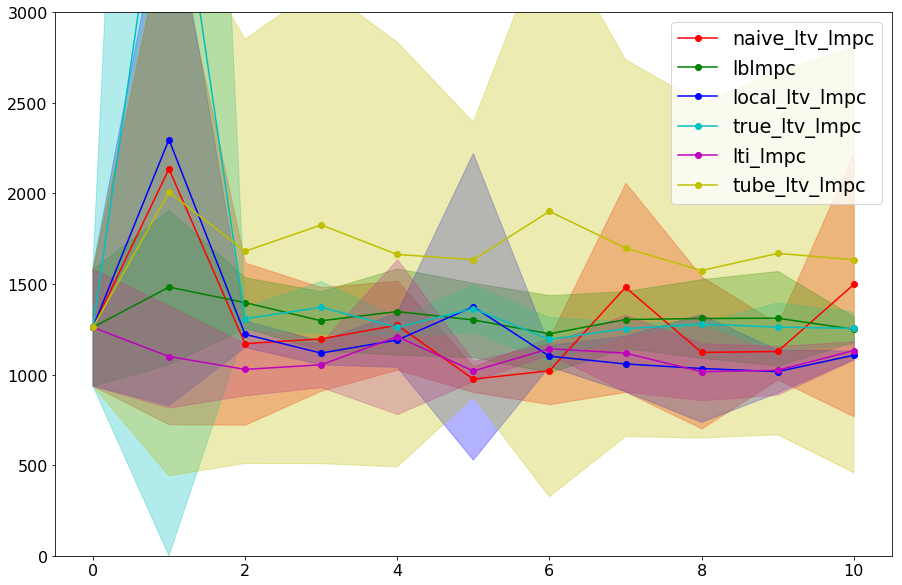

In [55]:
colors = ["r", "g","b","c","m","y","k"]
plt.figure(figsize=(15,10))
for iteration_cost,c in zip(iteration_costs, colors):
    experiment_utils.plot_with_cov(iteration_cost[:,4:], color=c)
plt.legend(controllers[1:])
plt.ylim((0,3000))

In [9]:
data_dicts=None

In [24]:
a = np.arange(10)

In [33]:
iteration_costs[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [128]:
import controlpy
A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])
As = [A + np.random.randn(2,2) for _ in range(100)]
K, P, _ = controlpy.synthesis.controller_lqr_discrete_time(A, B, 10*np.eye(2), np.eye(1))

In [129]:
A_clps = [A - B @ K for A in As]

In [130]:
def is_stable(A):
    return np.all(np.linalg.eigvals(A) <= 1)

In [135]:
A_stables = [A_clp for A_clp in A_clps if is_stable(A_clp)]

In [140]:
A_mults = [A_stables[0]]
for Am in A_stables[1:]:
    A_mults.append(A_mults[-1] @ Am)

In [142]:
for Am in A_mults:
    print(np.linalg.eigvals(Am.T @ Am))

[5.99976 0.07043]
[5.42189 0.09814]
[ 0.00266 13.26537]
[10.11192  0.00048]
[65.22965  0.00057]
[  0.00133 150.99666]
[ 0.00005 59.85935]
[  0.00038 399.68662]
[ 0.      17.52702]
[35.01532  0.     ]
[  0.      221.37104]
[609.56904   0.     ]
[  0.      338.63161]
[1944.11392    0.     ]
[   0.      3551.03435]
[5148.50167    0.     ]
[   0.      1209.88601]
[9141.35005   -0.     ]
[2648.63748    0.     ]
[    0.     10411.5515]
[    0.      25859.58769]
[45122.84863     0.     ]
[1674.24399    0.     ]
[   0.      3003.79043]
[13574.18778     0.     ]
[23832.97803    -0.     ]
[120445.34834      0.     ]
[     0.      403660.51044]
[119468.26315     -0.     ]
[34678.41876     0.     ]
[     0.      371197.00195]
[     0.      426404.28909]
[849586.00916      0.     ]
[      0.      2258320.92838]
[1201039.23756       0.     ]
[      0.      7798917.39254]
[3710252.3397       0.    ]
[      0.      8162157.18924]
[       0.      22557086.10441]
[      0.      1218825.05469]
[   0.    